# CORDIS portfolio analysis

## 0. Preamble

In [391]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [392]:
from create_topic_df import *
from indicators.two import cordis_topics
from nesta.core.orms.cordis_orm import Project
from indicators.two.cordis_topics import get_objects, get_iso2_to_id
from indicators.core.nlp_utils import parse_clean_topics
from indicators.two.thematic_indicators import INDICATORS,covid_topic_indexer
from indicators.core.config import EU_COUNTRIES
from sklearn.metrics import pairwise_distances
import pandas as pd
import altair as alt
import logging
from create_topic_df import *

from_date = INDICATORS["precovid_dates"]["from_date"] 

In [393]:
from gensim.models import HdpModel, Phrases,LdaModel
from gensim.models.phrases import Phraser
from gensim.corpora import Dictionary
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
from itertools import chain


stem = WordNetLemmatizer()
STOP = stopwords.words('english')
BAD = [x for x in string.punctuation + string.digits]
BAD.remove('-')

In [404]:
from networks import make_network_from_doc_term_matrix
from communities.algorithms import louvain_method
import community as community_louvain
from networkx import maximum_spanning_tree
from altair_network import plot_altair_network

In [395]:
from indicators.core.db import get_mysql_engine 
from nesta.core.orms.orm_utils import db_session, object_to_dict 
from nesta.core.orms.cordis_orm import Organisation as Org 
from nesta.core.orms.cordis_orm import ProjectOrganisation as Link 

In [396]:
from indicators.two import nih_topics
from indicators.two.nih_topics import get_objects as get_objects_nih

In [397]:
from scipy.spatial.distance import cosine

In [398]:
from sklearn.cluster import KMeans, DBSCAN

In [399]:
from hSBM_Topicmodel.sbmtm import sbmtm

In [40]:
from altair_save_utils import google_chrome_driver_setup, save_altair
driver = google_chrome_driver_setup()

[WDM] - ====== WebDriver manager ======
INFO:WDM:====== WebDriver manager ======
[WDM] - Current google-chrome version is 89.0.4389
INFO:WDM:Current google-chrome version is 89.0.4389
[WDM] - Get LATEST driver version for 89.0.4389
INFO:WDM:Get LATEST driver version for 89.0.4389


[WDM] - Get LATEST driver version for 89.0.4389
INFO:WDM:Get LATEST driver version for 89.0.4389
[WDM] - Trying to download new driver from https://chromedriver.storage.googleapis.com/89.0.4389.23/chromedriver_mac64.zip
INFO:WDM:Trying to download new driver from https://chromedriver.storage.googleapis.com/89.0.4389.23/chromedriver_mac64.zip
[WDM] - Driver has been saved in cache [/Users/jmateosgarcia/.wdm/drivers/chromedriver/mac64/89.0.4389.23]
INFO:WDM:Driver has been saved in cache [/Users/jmateosgarcia/.wdm/drivers/chromedriver/mac64/89.0.4389.23]


### Functions

In [10]:
# to go in data_utils

def covid_getter(text,covid_terms = ['covid','covid-19','coronavirus','sars-cov-2']):
    return any(x in text.lower() for x in covid_terms)

def make_country_weighted(geo_df,c_topics,country,weights):
    
    projects = geo_df.query("post_2020==False").query(f"country_code=='{country}'")
    
    topics = (c_topics
              .loc[c_topics['id'].isin(projects['id'])]
              .melt(id_vars='id')
              .assign(weight=lambda df: df['variable'].map(weights))
              .assign(weighted_value = lambda df: df['value']*df['weight']))
    
    return topics['weighted_value'].sum()

def get_project_shares(df,index_name='id'):
    
    return df['value'].sum()/len(set(df[index_name]))
    
# to go in NLP
def pre_process(text):
    
    lowercase = text.lower()
    no_numbers_symbols = ''.join([x for x in lowercase if x not in BAD])
    tokenised = [x for x in no_numbers_symbols.split(" ") if x not in STOP]
    lemmatised = [stem.lemmatize(x) for x in tokenised if len(x)>2]
    return lemmatised
    
def make_engram(corpus,n=3):
    c=2
    while c<= n:
        ngrammed = Phrases(corpus,min_count=3, threshold=100)
        corpus = ngrammed[corpus]
        c+=1
    return list(corpus)

def remove_extr_freq(corpus,high=0.999,low=5):
    
    freqs = pd.Series(chain(*corpus)).value_counts()
    very_high = freqs.quantile(high)
    drop_high = freqs[freqs>very_high].index.tolist()
    drop_low = freqs[freqs<low].index.tolist()
    
    print(drop_high)
    todrop = drop_high + drop_low
    
    corpus_filt = [[x for x in doc if x not in todrop] for doc in corpus]
    
    return corpus_filt   

# To go into network
def process_network(net, extra_edges=100):
    """Creates the base for a sector space network
    Args:
        sector_space (network): nx network object
        extra_edges (int): extra edges to add to the maximum spanning tree
    """

    max_tree = nx.maximum_spanning_tree(net)

    top_edges_net = nx.Graph(
        [
            x
            for x in sorted(
                net.edges(data=True),
                key=lambda x: x[2]["weight"],
                reverse=True,
            )
            if (x[0], x[1]) not in list(max_tree.edges())
        ][:extra_edges]
    )
    united_graph = nx.Graph(
        list(max_tree.edges(data=True)) + list(top_edges_net.edges(data=True))
    )

    pos = nx.kamada_kawai_layout(united_graph, dim=2)

    labs = {k: k for k, v in pos.items()}

    return pos, united_graph, labs
    

## 1. Read data 

In [11]:
# Read cordis data
cord_proj = get_objects(from_date=from_date)

# Read cordis geo-data
cord_geo_df = (pd.DataFrame(get_iso2_to_id())
                 .rename(columns={'project_rcn':'id'}))

# Read topics
cord_topics = parse_clean_topics(cordis_topics,binary_threshold=0.5)

In [12]:
# Find covid projects
cord_proj_df = pd.DataFrame(cord_proj)
cord_proj_df['is_covid'] = cord_proj_df['text'].apply(covid_getter)
cord_proj_df = cord_proj_df.loc[[isinstance(x,datetime.date) for x in cord_proj_df['created']]]

id_date_lookup = cord_proj_df.set_index('id')['created'].to_dict()

cord_topics['id'] = cord_proj_df['id']

/Users/jmateosgarcia/opt/anaconda3/envs/pivot/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
# NIH data

nih = get_objects_nih(from_date=from_date)
nih_df = pd.DataFrame(nih)

nih_df['is_covid'] = nih_df['text'].apply(covid_getter)

In [14]:
# Cordis orgs
engine = get_mysql_engine() 
with db_session(engine) as session: 
    query = session.query(Org, Link.project_rcn) 
    query = query.join(Org, Link.organization_id == Org.id) 
    query = query.filter(Org.country_code != "") 
    data = [{'project_rcn':rcn, **object_to_dict(org)} for org, rcn in query.all()] 

## 2. Analysis

### Basic statistics

In [46]:
cord_proj_df.query("is_covid==True")['funding'].sum()/1e6

222.126054

In [54]:
funding_shares = cord_proj_df.loc[cord_proj_df['created']>'2020-01-01'].groupby('is_covid')['funding'].sum()
100*funding_shares[True]/funding_shares.sum()

2.6098567007167675

In [90]:
# for x in list(cord_proj_df.query("is_covid==True")['title'].sample(10)):
#     print(x)
#     print('\n')

In [236]:
cord_proj_df['month_year'] = pd.to_datetime([datetime.date(x.year,x.month,1) for x in cord_proj_df['created']])
cord_trend = (cord_proj_df
              .loc[(cord_proj_df['month_year']>'2019-01-01')&(cord_proj_df['month_year']<'2021-01-06')]
              .groupby(['month_year','is_covid'])
              .size()
              .reset_index()
              .pivot_table(index='month_year',columns='is_covid',values=0)
              .fillna(0)
              .assign(share = lambda df: df[True]/df.sum(axis=1))['share']
              .reset_index(drop=False))

tr = (alt.Chart(cord_trend)
      .mark_line()
      .encode(x=alt.X('month_year',title=None),
             y=alt.Y('share',axis=alt.Axis(format='%'),title='Share of all projects'))
     ).properties(height=200,width=400)

save_altair(tr,'trend',driver=driver)
tr

/Users/jmateosgarcia/Desktop/projects/Pivot/figures


alt.Chart(...)

In [95]:
len(set(cord_geo_df.query("is_covid==True")['country_code']))

28

In [104]:
(cord_geo_df
 .query("post_2020 == True")
 .groupby(['is_covid','id'])
 .size()
 .reset_index(name='participants').groupby('is_covid')['participants'].mean())

is_covid
False    4.438506
True     5.127660
Name: participants, dtype: float64

In [113]:
big_projects = cord_geo_df.query("is_covid==True").groupby('id').size().sort_values(ascending=False).head(n=5).index.tolist()

cord_proj_df.loc[cord_proj_df['id'].isin(big_projects)]['title'].tolist()


['Multidisciplinary European network for research, prevention and control of the COVID-19 Pandemic',
 'EXaSCale smArt pLatform Against paThogEns for Corona Virus',
 'Rapid European SARS-CoV-2 Emergency research Response',
 'Translational approaches to disease modifying therapy of type 1 diabetes - HARVESTing the fruits of INNODIA',
 'Corona Accelerated R&D in Europe']

### Country representation in Covid research

In [15]:
# Create the Geo analysis
focus_project_id = set(cord_proj_df['id'])
covid_ids = set(cord_proj_df.query('is_covid==True')['id'])

In [16]:
# build geo df
cord_geo_df = (cord_geo_df.loc[cord_geo_df['id'].isin(focus_project_id)]
          .assign(post_2020=lambda df: [x.year >= 2020 for x in df['id'].map(id_date_lookup)])
          .assign(is_covid = lambda df: df['id'].isin(covid_ids))
         )

In [37]:
name_lookup = {'all_2020_share':'All projects in 2020','all_covid_share':'All Covid-19 related projects'}

In [42]:
post_2020 = cord_geo_df.query("post_2020 == True")

post_2020_shares = pd.concat([post_2020['country_code'].value_counts(normalize=True),
                              post_2020.query("is_covid==True")['country_code'].value_counts(normalize=True)],axis=1)

post_2020_shares.columns = ['all_2020_share','all_covid_share']

post_shares = post_2020_shares.loc[post_2020_shares.index.isin(EU_COUNTRIES)].reset_index(drop=False).fillna(0)

post_shares_long = (post_shares.melt(id_vars='index')
                  .reset_index(drop=False)
                  .assign(variable=lambda df: df['variable'].map(name_lookup)))  

sort_countries = post_shares.sort_values('all_covid_share',ascending=False)['index'].tolist()

ch = (alt.Chart(post_shares_long)
      .mark_point(filled=True)
      .encode(y=alt.Y('index',sort=sort_countries,title=None),
              x=alt.X('value',title='Share of activity'),
                      color='variable')).properties(height=450)

save_altair(ch,"1_shares",driver=driver)
ch

/Users/jmateosgarcia/Desktop/projects/Pivot/figures


alt.Chart(...)

### Country specialisation profiles and Covid research

In [18]:
cord_topics_dist = cord_topics.copy()

cord_topics_dist['is_covid'] = cord_topics_dist['id'].map(cord_proj_df.set_index('id')['is_covid'].to_dict())
cord_topics_dist = cord_topics_dist.drop(axis=1,labels=['id'])

In [19]:
sims = pd.DataFrame(1-pairwise_distances(cord_topics_dist.T,metric='cosine'),
                  index=cord_topics_dist.columns,columns=cord_topics_dist.columns)
covid_distances = sims['is_covid'].sort_values(ascending=False).drop(
    ['is_covid','infection immunity covid_19 coronavirus sars_cov_2']).to_dict()

In [124]:
top_similarities = (pd.Series(covid_distances)
                    .sort_values(ascending=False)
                    .head(n=10).reset_index().rename(columns={'index':'topic',0:'similarity'})
                    .to_markdown("figures/topic_similarity.md"))

In [20]:
rel_projects = pd.Series([make_country_weighted(
    cord_geo_df,
    cord_topics,c,covid_distances) for c in EU_COUNTRIES],index=EU_COUNTRIES,name='covid_related_projects')

In [167]:
activity = (pd.concat(
    [rel_projects,cord_geo_df.query("post_2020==False")['country_code']
     .value_counts()],axis=1)
            .dropna().sort_values('covid_related_projects',ascending=False))
activity_shares = activity/activity.sum(axis=0)

selected = activity_shares.loc[activity_shares['country_code']>0.01].index

rel_activity_spec = activity_shares.loc[
    activity_shares.index.isin(selected)].assign(
    related_spec=lambda df: df['covid_related_projects']/df['country_code']).sort_values('related_spec',ascending=False)

covid_spec = post_shares.set_index('index').assign(covid_spec = lambda df: df['all_covid_share']/df['all_2020_share'])

combined_specs = pd.concat([rel_activity_spec,covid_spec],axis=1).dropna().reset_index(drop=False)
combined_specs['spec_ratio'] = combined_specs['covid_spec']/combined_specs['related_spec']

spec_base = (alt.Chart(combined_specs)
            .encode(x=alt.X('covid_spec',scale=alt.Scale(zero=False),title='Covid representation'),
                       y = alt.Y('related_spec',scale=alt.Scale(zero=False),title='Related representation')))

spec_bubble = (spec_base.mark_point(filled=True,stroke='black',strokeWidth=0.5)
               .encode(size=alt.Size('all_2020_share',title='Share of 2020 participations'),
                                     tooltip=['index'],
                       color=alt.Color('spec_ratio',title='Specialisation ratios',
                                       scale=alt.Scale(scheme='Spectral',domainMid=1)))
              )

spec_text = (spec_base.mark_text(dx=15).encode(text=alt.Text('index')))

vert = alt.Chart(combined_specs).transform_calculate(x='1').mark_rule(stroke='grey',strokeDash=[2,1]).encode(x=alt.X('x:Q',title=''))
hor = alt.Chart(combined_specs).transform_calculate(y='1').mark_rule(stroke='grey',strokeDash=[2,1]).encode(y=alt.Y('y:Q',title=''))

rep_chart = (spec_bubble+spec_text+vert+hor).configure_legend(columns=2)

save_altair(rep_chart,'nat_repr',driver)
rep_chart


/Users/jmateosgarcia/Desktop/projects/Pivot/figures


alt.LayerChart(...)

In [22]:
# At the country level it doesn't look like there is a correspondence between countries with strong covid capabilities 
#and level of participation in covid projects

# What if we dig a bit deeper - org level?

### Org analysis

In [185]:
orgs = pd.DataFrame(data)

In [227]:
def cap_name(x):
    return ' '.join([w.lower().capitalize() for w in x.split(' ')])
    

In [231]:
orgs['is_covid']= orgs['project_rcn'].isin(covid_ids)

org_freqs = orgs.query("is_covid==True")[['name','country_code']].value_counts().reset_index(name='Covid participations').head(n=20)
org_freqs['name'] = [cap_name(n) for n in org_freqs['name']]

org_freqs.to_markdown("figures/org_representation.md",index=False)

In [187]:
org_shares = pd.concat([orgs.query(f"is_covid=={value}")['name']
              .value_counts(normalize=True)
              .reset_index(name='participation_share') 
              .assign(is_covid=value)[:500] for value in [True,False]])

orgs_sorted = org_shares.query("is_covid==True").sort_values('participation_share',ascending=False)['index'].tolist()[:30]

org_ch = (alt.Chart(org_shares)
          .transform_filter(alt.FieldOneOfPredicate('index',orgs_sorted))
          .mark_point(filled=True)
          .encode(y=alt.Y('index',sort=orgs_sorted),
                  x='participation_share',
                  color='is_covid')).properties(height=400)
org_ch

alt.Chart(...)

In [188]:
orgs['date'] = orgs['project_rcn'].map(id_date_lookup).dropna()

orgs_old = orgs.loc[orgs['date']<'2020-01-01']

def make_topic_average(org,orgs_df,project_df,topics_df):
    
    proj_ids = orgs_df.loc[orgs['name']==org]['project_rcn'].tolist()
    
    valid_ids = list(set(proj_ids) & set(project_df['id']))
    
    project_topics = topics_df.set_index('id').loc[valid_ids]
    average = project_topics.mean()
    return average

covid_orgs = list(set(orgs.query("is_covid==True")['name']))

random_group = [x for x in list(set(orgs.query("is_covid==False")['name'].sample(200))) if x not in covid_orgs]

In [190]:
org_averages = pd.DataFrame([make_topic_average(org,orgs_old,
                                               cord_proj_df,cord_topics) for org in covid_orgs+random_group],index=covid_orgs+random_group)

In [191]:
covid_mean = cord_topics.set_index('id').loc[covid_ids].mean()

In [201]:
def get_similarity(v1,v2,x):
    return 1-cosine(np.array(v1),np.array(v2))

In [202]:
cov_similarities = pd.Series([get_similarity(covid_mean,org_averages.loc[x],x) for 
                x in org_averages.index],index=org_averages.index).reset_index(name='proximity')

In [203]:
cov_similarities['is_covid'] = cov_similarities['index'].isin(covid_orgs)

In [223]:
cov_sim_means = cov_similarities.groupby('is_covid')['proximity'].mean()
cov_sim_means

is_covid
False    0.519590
True     0.647357
Name: proximity, dtype: float64

In [224]:
cov_sim_means[True]/cov_sim_means[False]

1.2458989529369777

In [215]:
cov_sims = cov_similarities.dropna().reset_index(drop=False)

boxp = alt.Chart(cov_sims).mark_boxplot().encode(y=alt.Y('is_covid',title=['Covid', 'participant']),
                                                 x=alt.X('proximity',title='Profile similarity'),
                                                 color=alt.Color('is_covid',legend=None)).properties(height=100)
save_altair(boxp,'similarity_boxplot',driver)

/Users/jmateosgarcia/Desktop/projects/Pivot/figures


In [221]:
from scipy.stats import ttest_ind

ttest_ind(cov_sims.query("is_covid==False")['proximity'],
          cov_sims.query("is_covid==True")['proximity'])

Ttest_indResult(statistic=-9.125144182084505, pvalue=1.0619435003827446e-17)

In [234]:
non_part_high_sim = [cap_name(x) for x in cov_distances.query("is_covid==False").sort_values('proximity',ascending=False)['index'][:15]]
', '.join(non_part_high_sim)

'Medizinische Universitat Innsbruck, London School Of Hygiene And Tropical Medicine Royal Charter, Genome Research Limited, Universitaetsklinikum Bonn, Fundacio Institut De Recerca Contra La Leucemia Josep Carreras, Klinikum Rechts Der Isar Der Technischen Universitat Munchen, Istituto Superiore Di Sanita, The University Of Sheffield, The Provost, Fellows, Foundation Scholars & The Other Members Of Board Of The College Of The Holy & Undivided Trinity Of Queen Elizabeth Near Dublin, Mosaiques Diagnostics Gmbh, Merck Sharp & Dohme Corp, University College London, University College Dublin, National University Of Ireland, Dublin, Alzheimer Europe, Universite De Geneve'

In [235]:
non_part_high_sim = [cap_name(x) for x in cov_distances.query("is_covid==True").sort_values('proximity',ascending=True)['index'][:15]]
', '.join(non_part_high_sim)

'Dompe Farmaceutici Spa, International Institute Of Molecular And Cell Biology, Bundesministerium Der Verteidigung, Aicuris Anti-infective Cures Gmbh, Content Flow Gmbh, Hpnow Aps, Elettra - Sincrotrone Trieste Scpa, Tretbox Gmbh, Xsensio Sa, Sun Yat-sen University, Fondazione Icons, Institut Pasteur Of Shanghai, Chinese Academy Of Sciences, Eyefree Assisting Communication Ltd, Cobra Biopharma Matfors Ab, Biosistemika, Raziskave In Razvoj Doo'

### Topic analysis

In [23]:
obs = cord_proj_df.query("created>'2020-01-01'")['text'].tolist()
pre_processed = [pre_process(x) for x in obs]
engram = make_engram(pre_processed)

In [24]:
post = remove_extr_freq(engram,high=0.995)

['project', 'research', 'new', 'system', 'study', 'technology', 'model', 'approach', 'development', 'aim', 'data', 'process', 'cell', 'use', 'develop', 'novel', 'using', 'also', 'material', 'provide', 'energy', 'method', 'impact', 'european', 'based', 'knowledge', 'understanding', 'field', 'different', 'network', 'analysis', 'first', 'well', 'human', 'tool', 'time', 'application', 'result', 'potential', 'key', 'high', 'one', 'design', 'however', 'mechanism', 'two', 'social', 'innovative', 'level', 'challenge', 'activity', 'solution', 'role', 'change', 'current', 'control', 'interaction', 'science', 'strategy', 'technique', 'future', 'objective', 'information', 'europe', 'dynamic', 'structure', 'work', 'within', 'developed', 'used', 'molecular', 'global', 'effect', 'environment', 'group', 'including', 'complex', 'goal', 'disease', 'training', 'scientific', 'device', 'important', 'market', 'need', 'industry', 'innovation', 'function', 'protein', 'address', 'production', 'thus', 'large', 

In [25]:
model_2020 = sbmtm()
model_2020.make_graph(post,documents=range(len(post)))

In [26]:
model_2020.fit()
model_2020.plot(nedges=1000)

In [27]:
sbmtm_2020_df = post_process_model(model_2020,top_level=0)

In [356]:
sbm_2020_processed = filter_topics(sbmtm_2020_df,presence_thr=0.05,prevalence_thr=0.1)[0].applymap(lambda x: x>0.05)

crucial_ability_lack_often_since                      0.463565
limited_active_able_generate_required                 0.301822
increasing_consortium_access_effort_overall           0.187592
collaboration_expert_team_value_centre                0.133432
brthe_making_bring_especially_around                  0.121861
                                                        ...   
deep_variability_high-resolution_zone_simulate        0.001723
position_protection_transform_forefront_protect       0.001723
physical_limit_extremely_construct_exploration        0.001477
healthcare_month_day_treated_quality_life             0.001231
induced_controlling_modulation_induce_accumulation    0.000985
Length: 252, dtype: float64


In [357]:
sbm_2020_processed['id'] = cord_proj_df.query("created>'2020-01-01'")['id'].tolist()
sbm_2020_processed['is_covid'] = sbm_2020_processed['id'].isin(covid_ids)

#Melt 
sbm_2020_shares = sbm_2020_processed.melt(id_vars=['is_covid','id']).groupby(['is_covid','variable']).apply(get_project_shares)

focus_topics = sbm_2020_shares[True].sort_values(ascending=False).index.tolist()[:50]

sbm_2020_plot = sbm_2020_shares.reset_index(name='project_shares')

project_topic_chart = (alt.Chart(sbm_2020_plot)
                       .mark_point(filled=True)
                       .transform_filter(alt.FieldOneOfPredicate('variable',focus_topics))
                       .encode(y=alt.Y('variable',sort=focus_topics),
                               x='project_shares',
                               color='is_covid')).properties(height=550)
project_topic_chart

alt.Chart(...)

### Topic network


In [444]:
net = make_network_from_doc_term_matrix(sbm_2020_processed.drop(axis=1,labels=['is_covid']),threshold=0.2,id_var='id')

In [448]:
net2 = process_network(net,extra_edges=100)

In [449]:
comms = community_louvain.best_partition(net2[1],resolution=1)

In [510]:
comm_groups = pd.Series(comms).reset_index(name='comm').groupby('comm')

comm_names = comm_groups.apply(lambda x: ' '.join(list(x['index'])))

# for k in comm_names.keys():
    
#     print(comm_names[k])
#     print('\n')
comm_name_lookup = {0:'health_neurology',
                   1:'social_sciences_policy_proposal',
                   2:'biochemistry',
                   3:'epidemiology',
                   4:'electronics',
                   5:'environmental',
                   6:'ai_cybersecurity',
                   7:'physics',
                   8:'products_technology',
                   9:'humanities',
                   10:'climate_science'}

In [511]:
# Size (number of topic co-occurrences in the corpus)
all_topics = (sbm_2020_processed.drop(axis=1,labels=['is_covid','id']).applymap(lambda x: x>0.05).sum()).to_dict()

In [512]:
node_df = (pd.DataFrame(net2[0]).T
            .reset_index(drop=False)
            .rename(columns={0: "x", 1: "y", "index": "node"})
            .assign(size=lambda df: df['node'].map(all_topics))
            .assign(comm = lambda df: df['node'].map(comms).map(comm_name_lookup))
           .assign(node_name=lambda df: df['node']))

all_net = plot_altair_network(node_df,net2[1],node_label='node_name',node_size='size',node_color='comm',show_neighbours=False,
                    **{'node_size_title':'Appearances in corpus',
                       'node_color_title':'Subject','edge_weight_title':'co-occurrences','title':'H2020 2020 projects topic network'},
                    edge_scale=0.1,
                    edge_opacity=0.05).properties(width=700,height=400)

In [513]:
# plot_altair_network(node_df,net2[1],node_label='node_name',node_size='size',node_color='comm',
#                     show_neighbours=False,
#                     **{'edge_weight_title':'co-occurrences','title':'H2020 2020 projects topic network',
#                       'node_size_title':'la','node_color_title':'la'})

In [514]:
covid_topics = sbm_2020_processed.loc[sbm_2020_processed['is_covid']==True].drop(axis=1,labels=['is_covid','id']).applymap(lambda x: x>0.05).sum()

keep_topics = covid_topics.loc[covid_topics>1].index.tolist()
covid_size_dict = covid_topics.loc[keep_topics].to_dict()

covid_node_df = (node_df.assign(size=lambda df: df['node'].map(covid_size_dict)))

cov_net = plot_altair_network(covid_node_df,net2[1],node_label='node_name',node_size='size',
                              node_color='comm',
                              show_neighbours=False,
                    **{'node_size_title':'Appearances in corpus',
                       'node_color_title':'Subject','edge_weight_title':'co-occurrences','title':'H2020 Covid projects topic network'},
                    edge_scale=0.1,
                    edge_opacity=0.05).properties(width=700,height=400)



In [515]:
h2020_topics = alt.vconcat(all_net,cov_net).resolve_scale(size='independent')

save_altair(h2020_topics,'topic_network',driver=driver)

h2020_topics

/Users/jmateosgarcia/Desktop/projects/Pivot/figures


alt.VConcatChart(...)

### Identify novelty

In [567]:
covid_sbm = sbm_2020_processed.query("is_covid==True").drop(axis=1,labels=['is_covid']).set_index('id')

In [706]:
def make_distances(n_clust):
    
    km = KMeans(n_clusters=n_clust,n_init=20)
    km.fit(covid_sbm)

    lab_lookup = {_id:clust for _id,clust in zip(covid_sbm.index,km.labels_)}

    clust_titles = cord_proj_df.assign(clust = lambda df: df['id'].map(lab_lookup)).groupby('clust')['title'].apply(lambda x: list(x))
    
    distances = []

    for x in covid_sbm.index:

        dists = []

        for cl in range(n_clust):

            d = cosine(covid_sbm.loc[x],km.cluster_centers_[cl,:])
            dists.append(d)
        distances.append(dists)
        
    mean_dists = pd.Series([np.median(x) for x in distances],index=covid_sbm.index)
    return mean_dists
    

In [710]:
dists = pd.concat([make_distances(n) for n in range(1,15)],axis=1)
mean_dists = dists.mean(axis=1).sort_values(ascending=False)

In [711]:
def make_title_table(n=5):
    
    high = ', '.join([cord_proj_df.query(f"id=={n}")['title'].iloc[0] for n in mean_dists.head(n=n).index])
    low = ', '.join([cord_proj_df.query(f"id=={n}")['title'].iloc[0] for n in mean_dists.tail(n=n).index])
    
    table = pd.DataFrame({'category':['High eccentricity','Low eccentricity'],'examples':[high,low]})
    return table

In [713]:
make_title_table().to_markdown("figures/eccentricity_table.md",index=False)

### Novelty and eccentricity

In [714]:
nov_merged = (orgs.merge(cov_similarities,left_on='name',right_on='index')
              .merge(median_dists.reset_index(name='mean_dist'),left_on='project_rcn',right_on='id')
             )[['name','proximity','mean_dist']]

In [715]:
nov_merged[['proximity','mean_dist']].corr()

,proximity,mean_dist
proximity,1.000000,0.030511
mean_dist,0.030511,1.000000


In [716]:
cord_proj_df.loc[cord_proj_df['id'].isin(mean_dists.head(n=5).index)]['funding'].median()/1e6

cord_proj_df.loc[cord_proj_df['id'].isin(mean_dists.tail(n=5).index)]['funding'].median()/1e6

id_budget_lookup = cord_proj_df.query("is_covid==True")[['id','funding']]

corr = mean_dists.reset_index(name='mean_distance').merge(id_budget_lookup,on='id').set_index('id')[['mean_distance','funding']]

#corr.plot.scatter('mean_distance','funding',loglog=True)

In [705]:
#sbm_2020_processed.set_index('id').drop(axis=1,labels=['is_covid']).loc[mean_dists.head(n=10).index].sum().sort_values(ascending=False)[:10]
#sbm_2020_processed.query("is_covid==True").set_index('id').drop(axis=1,labels=['is_covid']).sum().sort_values(ascending=False)[:10]

### NIH comparison





In [195]:
# Combined dataset

covid_combined = pd.concat([df.query("is_covid==True")
                            .assign(location = region)[['id','text','location']] for df,region in zip([c_df,nih_df],['EU','US'])],axis=0)

In [199]:
def pre_process_pipe(corp,high=0.995):
    pre_processed = [pre_process(x) for x in corp]
    engram = make_engram(pre_processed)
    post = remove_extr_freq(engram,high=high)
    return post

In [201]:
# Projects

comp_text = covid_combined['text'].tolist()

proc_text = pre_process_pipe(comp_text,high=0.999)


['covid', 'sarscov', 'infection', 'disease', 'study', 'virus', 'patient', 'response', 'cell', 'aim', 'human']


In [203]:
model_2 = sbmtm()
model_2.make_graph(proc_text,documents=list(covid_combined['id']))
model_2.fit()

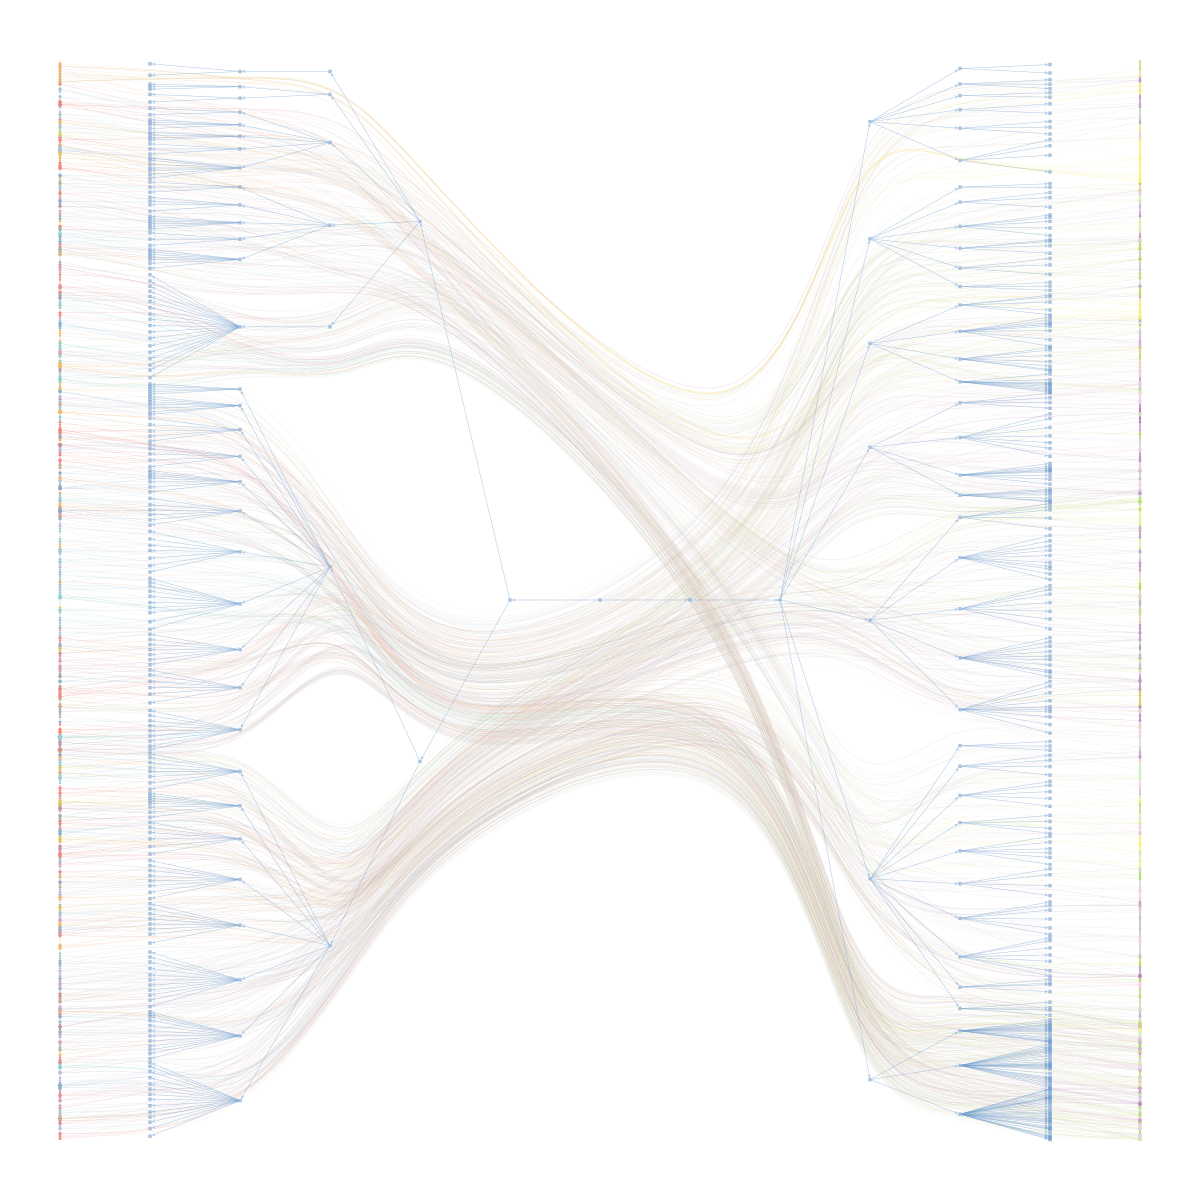

In [204]:
model_2.plot(nedges=1000)

In [210]:
bench_topic_df = post_process_model(model_2,top_level=0)

In [348]:
bench_topic_df_2 = filter_topics(bench_topic_df,presence_thr=0.015,prevalence_thr=0.1)[0].applymap(lambda x: x>0.05)

In [349]:
covid_country_lookup = covid_combined.assign(id = lambda df: [str(x) for x in covid_combined['id']]).set_index('id')['location'].to_dict()

In [350]:
bench_topic_df_2_ = (bench_topic_df_2.reset_index(drop=False)
                    .assign(country = lambda df: df['index'].map(covid_country_lookup)))

country_shares = bench_topic_df_2_.melt(id_vars=['country','index']).groupby(['country','variable']).apply(lambda x: get_project_shares(x,
                                                                                                                                      'index'))
top_topics = country_shares['EU'].sort_values(ascending=False)[:50].index.tolist()

sbm_plot_2 = country_shares.reset_index(name='project_shares')

benchmark_topic_chart = (alt.Chart(sbm_plot_2)
                       .mark_point(filled=True)
                       .transform_filter(alt.FieldOneOfPredicate('variable',top_topics))
                       .encode(y=alt.Y('variable',sort=top_topics),
                               x='project_shares',
                               color='country')).properties(height=550)
benchmark_topic_chart


alt.Chart(...)

In [717]:
2*5000/100

100.0